In [5]:
get_ipython().system('pip install hurst fbprophet matplotlib yfinance numpy statsmodels datetime pandas_market_calendars')


/usr/lib/python3/dist-packages/secretstorage/dhcrypto.py:15: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/usr/lib/python3/dist-packages/secretstorage/util.py:19: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes


In [6]:


import yfinance
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
import datetime
from datetime import timedelta
from datetime import date
import pandas_ta as ta
import statsmodels.tsa.stattools as ts
from hurst import compute_Hc
from fbprophet import Prophet
import pandas_market_calendars as mcal
from finta import TA

from scipy.stats import ttest_ind


# In[408]:



In [7]:


n_forward = 1
name = 'BTC-USD'
#name = 'GLD'
#name = 'SPY'
#name = 'GOOG'

#strategy = "EMA"
strategy = "SMA"
#indicator = 'Close'
indicator = 'VWP'

w=117
end_date = datetime.date.today()
#end_date = datetime.date.today() - timedelta(weeks=w)
end_date1 = end_date - timedelta(weeks=w)
start_date = end_date1 - timedelta(weeks=w)


# In[409]:


In [10]:


nyse = mcal.get_calendar('NYSE')
nyse_trading_dates= nyse.schedule(start_date=start_date, end_date=end_date+timedelta(days=n_forward))

ticker = yfinance.Ticker(name)
data = ticker.history(interval="1d",start=start_date,end=end_date, auto_adjust=True)
data['Forward Close'] = data['Close'].shift(-n_forward)
data['Forward Return'] = (data['Forward Close'] - data['Close'])/data['Close']
data['VWP'] = data['Close']*data['Volume']

Short_EVWMA = pd.DataFrame(TA.EVWMA(data,12))
Long_EVWMA = pd.DataFrame(TA.EVWMA(data,26))
Short_EVWMA.columns = ['EVWMA_12']
Long_EVWMA.columns = ['EVWMA_26']

#p 209 of ttr doc
MACD_EVWMA = pd.DataFrame(Short_EVWMA['EVWMA_12'] - Long_EVWMA['EVWMA_26'])
MACD_EVWMA.columns = ['MACD-line']

Signal_EVWMA = pd.DataFrame(ta.ema(MACD_EVWMA["MACD-line"], length=9))
Signal_EVWMA.columns = ['Signal_EMA_9_MACD']
data['MACD_Signal'] = Signal_EVWMA

benchName = "^GSPC"
bench = yfinance.Ticker(benchName)
benchData = bench.history(interval="1d",start=start_date,end=end_date, auto_adjust=True)
len(benchData)
len(data)



/usr/local/lib/python3.6/dist-packages/pandas/core/internals/construction.py:791: FutureWarning:

Converting timezone-aware DatetimeArray to timezone-naive ndarray with 'datetime64[ns]' dtype. In the future, this will return an ndarray with 'object' dtype where each element is a 'pandas.Timestamp' with the correct 'tz'.
	To accept the future behavior, pass 'dtype=object'.
	To keep the old behavior, pass 'dtype="datetime64[ns]"'.



1635

In [11]:


dateindex = data.loc[start_date:end_date].index
dateindex_ = [start_date + datetime.timedelta(days=x) for x in range(0, ((end_date)-start_date).days)]
dateindex_n_forward = [start_date + datetime.timedelta(days=x) for x in range(0, ((end_date+ timedelta(days=n_forward))-start_date).days)]

dateindex2 = data.loc[end_date1:end_date].index

dateindex2_n_forward = [end_date1 + datetime.timedelta(days=x) for x in range(0, ((end_date+ timedelta(days=n_forward))-end_date1).days)]




In [12]:


#if(len(data)==len(dateindex_)):
if(len(data)>len(nyse_trading_dates)):
    frequency=pd.DataFrame(dateindex_n_forward).set_index(0)
    
else:
    frequency=nyse_trading_dates
    #frequency = pd.DataFrame(frequency).set_index(0).index
    
frequency = frequency.index

idx2 = frequency

#https://stackoverflow.com/questions/40815238/python-pandas-convert-index-to-datetime
idx2 = pd.to_datetime(idx2, errors='coerce')


In [13]:

prices = data.loc[~data.index.duplicated(keep='last')]        
prices = data.reset_index()

idx1 = prices.set_index('Date').index  

merged = idx1.union(idx2)
s = prices.set_index('Date').reindex(merged)
df = s.interpolate().dropna(axis=0, how='any')

data = df


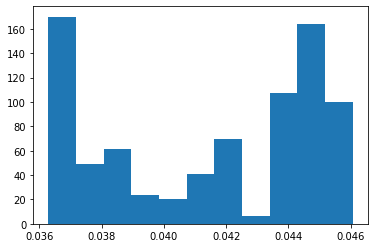

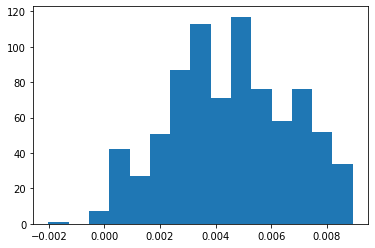

In [14]:

limit = 100

train_size = 0.5

trades = []
expectedReturns = []

sdevs = []

minExpectedReturn = 0

width1 = len(data.loc[start_date:end_date1].index)
width2 = len(data.loc[end_date1+timedelta(days=1):end_date].index)

for i in range(0,width1):
    temp = data.loc[frequency[i]:frequency[i+width2]].copy()
    
    adf_results = ts.adfuller(temp['Close'], 1)
    H, c, val = compute_Hc(temp['Close'], kind='price', simplified=True)
    
    #dateToBeSold = ((official_trading_dates.loc[i][0].strftime('%Y-%m-%d')+n_forward).strftime('%Y-%m-%d') 
    
    #ts1 = pd.DataFrame()
    #ts1["Date"] = temp.index
    #ts1[indicator] = temp.VWP.values
    #ts1.columns = ['ds', 'y']

    #no need to strip last day from model becuase df_inner (which ts is based on) is already -2
    #m = Prophet(daily_seasonality=True,yearly_seasonality=True)
    #m.add_seasonality(name='monthly', period=30.5, fourier_order=5)
    #m.add_seasonality(name='quarterly', period=91.25, fourier_order=7)
    #m.fit(ts1)

    #forecast only last day in model (can verify result) needs to be based on df.loc (similar to df_inner)
    #forecast = pd.DataFrame([pd.DataFrame(official_trading_dates.index).loc[pd.DatetimeIndex(official_trading_dates.index).get_loc(temp.index[-1].strftime('%Y-%m-%d'))+n_forward-2][0].strftime('%Y-%m-%d')])
    #forecast = pd.DataFrame([(temp.index[-1] + timedelta(days=n_forward)).strftime('%Y-%m-%d')]) 
    #forecast = pd.DataFrame([frequency[pd.DataFrame(frequency).set_index('Date').index.get_loc(dateindex[i])+n_forward].strftime('%Y-%m-%d')])
    
    #forecast.columns = ['ds']

    #Predict and plot
    #pred = m.predict(forecast)
                
    result = []
    
    for ma_length in range(20,limit):        
        
        if strategy == "EMA":
            
            temp[strategy] = ta.ema(temp[indicator], length=ma_length)
            temp['input'] = [int(x) for x in temp[indicator] > temp[strategy]]
            
        elif strategy == "SMA":
            
            temp[strategy] = temp[indicator].rolling(ma_length).mean()
            temp['input'] = [int(x) for x in temp[indicator] > temp[strategy]]
                
        df = temp.dropna()
        
        training = df.head(int(train_size * df.shape[0]))
        test = df.tail(int((1 - train_size) * df.shape[0]))
        
        tr_returns = training[training['input'] == 1]['Forward Return']
        test_returns = test[test['input'] == 1]['Forward Return']
        
        mean_forward_return_training = tr_returns.mean()
        mean_forward_return_test = test_returns.mean()
        pvalue = ttest_ind(tr_returns,test_returns,equal_var=False)[1]

        result.append({
            'ma_length':ma_length,
            'training_forward_return': mean_forward_return_training,
            'test_forward_return': mean_forward_return_test,
            'p-value':pvalue
        })
    
    result.sort(key = lambda x : -x['training_forward_return'])
    
    if strategy == "EMA":
        temp[strategy] = ta.ema(temp[indicator], length=result[0]['ma_length'])
        
    elif strategy == "SMA":
        temp[strategy] = temp[indicator].rolling(result[0]['ma_length']).mean()
       
    if H > 0.5 or adf_results[1] > 0.05 or temp.iloc[-1]['MACD_Signal'] > 0:
        trades.append(temp.index[-1].strftime('%Y-%m-%d'))
        expectedReturns.append((result[0]['training_forward_return']+result[0]['test_forward_return'])/2)
        sdevs.append(np.std(temp['Forward Return']))
        
    #t test passed
    elif result[0]['p-value'] > .1:

        if result[0]['training_forward_return'] > minExpectedReturn:
            if result[0]['test_forward_return'] > minExpectedReturn:

                #just MA strategy
                #if H > 0.5 or adf_results[1] > 0.05 or temp['MACD_Signal'] > 0 or 
                if (temp.iloc[-1][indicator]>temp.iloc[-1][strategy]):
                    trades.append(temp.index[-1].strftime('%Y-%m-%d'))
                    expectedReturns.append((result[0]['training_forward_return']+result[0]['test_forward_return'])/2)
                    sdevs.append(np.std(temp['Forward Return']))

                    #print(result[0])
                    #print(temp[-1:][indicator])

                    #print(temp[-1:][strategy])

                    #plt.plot(temp[indicator],label=name)

                    #stringLabel = str(result[0]['ma_length']) + " " + strategy + " at " + str(n_forward) + " day return " + str(result[0]['test_forward_return'].round(3))

                    #plt.plot(temp['Close'].rolling(result[0]['ma_length']).mean(),label = stringLabel)
                    #plt.plot(temp[indicator].rolling(result[0]['ma_length']).mean(),label = stringLabel)

                    #plt.legend()

                    #plt.show()

                    #plt.hist(temp['Forward Return'], bins='auto')  # arguments are passed to np.histogram
                    #plt.show()        

plt.hist(sdevs, bins='auto')  # arguments are passed to np.histogram
plt.show()
plt.hist(expectedReturns, bins='auto')  # arguments are passed to np.histogram
plt.show()




(array([  1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   1.,   1.,   1.,   0.,   1.,   0.,   3.,   1.,   3.,
          2.,   2.,   3.,  11.,   6.,  11.,  18.,  15.,  25.,  34.,  45.,
         65.,  99., 113.,  83.,  63.,  45.,  37.,  27.,  19.,  16.,   8.,
          6.,   6.,  11.,   5.,   3.,   3.,   5.,   3.,   2.,   2.,   2.,
          1.,   0.,   0.,   0.,   1.,   0.,   1.,   0.,   2.]),
 array([-0.37169513, -0.36519327, -0.35869141, -0.35218956, -0.3456877 ,
        -0.33918584, -0.33268398, -0.32618212, -0.31968027, -0.31317841,
        -0.30667655, -0.30017469, -0.29367283, -0.28717098, -0.28066912,
        -0.27416726, -0.2676654 , -0.26116354, -0.25466169, -0.24815983,
        -0.24165797, -0.23515611, -0.22865425, -0.2221524 , -0.21565054,
        -0.20914868, -0.20264682, -0.19614496, -0.189

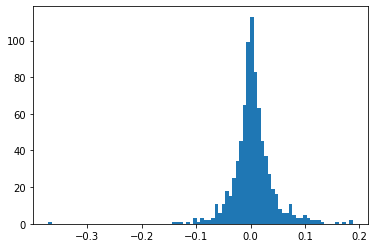

In [15]:


start = 1000

set = pd.DataFrame()
for i in range(0,len(trades)):
    
    value = pd.DataFrame(data.loc[trades[i]]).transpose()
    value['ExpectedReturn'] = expectedReturns[i]
    value['sdev'] = sdevs[i]
    set = pd.concat([set,value])


plt.hist(set['Forward Return'], bins='auto')  # arguments are passed to np.histogram

In [16]:


orderbook = pd.DataFrame()

#temp = pd.DataFrame([dateToBeSold,1],columns=['date','qty'])
column_names = ["date", "qty"]

sellDates = pd.DataFrame(columns = column_names)

#set[dateindex2[1].strftime('%Y-%m-%d')]
for i in dateindex2:
    
    idate = i.strftime('%Y-%m-%d')        
    
    #process purchases
    if (idate in set.index):

        temp = pd.DataFrame()
        
        estRet = set.loc[idate]['ExpectedReturn']

        temp['orderside'] = ['buy']        
        
        if len(data[start_date:idate])-1+n_forward>=len(data[start_date:]):
            dateToBesold = np.nan    
            #dateToBeSold = frequency[frequency.get_loc(idate)+n_forward].strftime('%Y-%m-%d')
            #frequency[pd.DataFrame(frequency).set_index('Date').index.get_loc(dateindex[i])+n_forward].strftime('%Y-%m-%d')
            temp['valueAtSale'] = np.nan
        else:
            
            #dateToBeSold = data.iloc[len(data[start_date:idate])-1+n_forward].name.strftime('%Y-%m-%d') 
            dateToBeSold = frequency[frequency.get_loc(datetime.datetime.strptime(idate, "%Y-%m-%d").date())+n_forward].strftime('%Y-%m-%d')
            #frequency[pd.DataFrame(frequency).set_index('Date').index.get_loc(dateindex[i])+n_forward].strftime('%Y-%m-%d')
            
            #temp['valueAtSale'] = pd.DataFrame(data.iloc[len(data[start_date:idate])-1+n_forward]).transpose()['Close'].values[0]            
            temp['valueAtSale'] = data.loc[dateToBeSold]['Close']
         
        temp['date'] = [idate]
        temp['valueAtPurchase'] = set.loc[idate]['Close']
        temp['estRet'] = estRet
        #temp['qty'] = Qty
        temp['dateBought'] = idate        
        temp['dateToBeSold'] = dateToBeSold
        
        btemp = pd.DataFrame(columns = column_names)
        btemp["date"]=[dateToBeSold]
        #btemp["qty"]=[Qty]

        sellDates = sellDates.append(btemp,ignore_index=True)
  
        temp = temp.round(4)

        orderbook = orderbook.append(temp,ignore_index=True)
        
for i in dateindex2:
    
    idate = i.strftime('%Y-%m-%d')        
    
    #process sales
        
    if (idate in sellDates.set_index('date').index):    
        temp = pd.DataFrame()

        dateBought = frequency[frequency.get_loc(datetime.datetime.strptime(idate, "%Y-%m-%d").date())-n_forward].strftime('%Y-%m-%d')
        #frequency[pd.DataFrame(frequency).set_index('Date').index.get_loc(dateindex[i])-1-n_forward].strftime('%Y-%m-%d')
        #dateBought = data.iloc[len(data[start_date:idate])-1-n_forward].name.strftime('%Y-%m-%d')   
        
        dateToBeSold = idate
        temp['dateBought'] = [dateBought]
        temp['dateToBeSold'] = dateToBeSold
        #temp['valueAtPurchase'] = pd.DataFrame(data.iloc[len(data[start_date:idate])-1-n_forward]).transpose()['Close'].values[0]
        temp['valueAtPurchase'] = data.loc[dateBought]['Close']
        estRet = set.loc[dateBought]['ExpectedReturn']
        temp['estRet'] = estRet
        temp['valueAtSale'] = data.loc[dateToBeSold]['Close']
        #temp['valueAtSale'] = pd.DataFrame(data.iloc[len(data[start_date:idate])-1]).transpose()['Close'].values[0]
        
        #temp['dateToBeSold'] = idate
        #temp['estRet'] = data.loc[idate]['Forward Return']

        temp['orderside'] = ['sell']        
        temp['date'] = [idate]

        #data vs set because set only includes buy dates
        #temp['valueAtSale'] = pd.DataFrame(data.ix[len(data[start_date:idate])-1+n_forward]).transpose()['Close']

        #temp['qty'] = sellDates.set_index('date').loc[idate]['qty']

        temp = temp.round(4)

        orderbook = orderbook.append(temp,ignore_index=True)


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7138: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.




In [17]:
orderbook.sort_values(by=['date','orderside'], ascending=True)


,date,dateBought,dateToBeSold,estRet,orderside,valueAtPurchase,valueAtSale
0,2018-12-06,2018-12-06,2018-12-07,0.0071,buy,3521.10,3419.94
1,2018-12-07,2018-12-07,2018-12-08,0.0072,buy,3419.94,3476.11
808,2018-12-07,2018-12-06,2018-12-07,0.0071,sell,3521.10,3419.94
2,2018-12-08,2018-12-08,2018-12-09,0.0067,buy,3476.11,3614.23
809,2018-12-08,2018-12-07,2018-12-08,0.0072,sell,3419.94,3476.11
...,...,...,...,...,...,...,...
806,2021-02-23,2021-02-23,2021-02-24,0.0047,buy,48824.43,49705.33
1610,2021-02-23,2021-02-22,2021-02-23,0.0045,sell,54207.32,48824.43
807,2021-02-24,2021-02-24,2021-02-25,0.0045,buy,49705.33,47093.85
1611,2021-02-24,2021-02-23,2021-02-24,0.0047,sell,48824.43,49705.33


In [18]:

funds = 1000
BuyFundsPercent = .75
percentHeldOnSell = 1

buyLog = pd.DataFrame()
sellLog = pd.DataFrame()
runningLog = pd.DataFrame()

held = 0
upper = 0
lower = 0

for i in dateindex2:
    
    temp = pd.DataFrame()
    rtemp = pd.DataFrame()
    _temp = pd.DataFrame()
    
    t = i.strftime('%Y-%m-%d')
    
    subset = orderbook[orderbook['date']==t]
    gain = 0
    paid = 0
    
    if len(subset) != 0:
        
        sales = subset[subset['orderside'] == 'sell']
        
        #print("date " + str(i))
        
        if len(sales) != 0:                        
            
            oldvalue = sales['valueAtPurchase'].values[0]

            newvalue = sales['valueAtSale'].values[0]            
            
            Qty = buyLog.set_index('date').loc[sales['dateBought'].values[0]].values[0]
            #print("Qty sold " + str(Qty.round(2)))
            
            gain = newvalue * Qty
            
            _temp['date'] = [i]
            _temp['qty'] = [Qty]
            
            sellLog = sellLog.append(_temp)
    
        purchases = subset[subset['orderside'] == 'buy']
        
        if len(purchases) != 0:
    
            ProportionOfFunds = funds * BuyFundsPercent
        
            Qty = ProportionOfFunds / purchases['valueAtPurchase'].values[0]
            #print(purchases['valueAtPurchase'].values[0])
            #print("Qty purchased " + str(Qty.round(2)))
            
            temp['date'] = [i]
            temp['qty'] = [Qty]
            
            paid = purchases['valueAtPurchase'].values[0]*Qty
                        
            buyLog = buyLog.append(temp)
        
        funds = funds + gain - paid
                    
        rtemp['date'] =  [i]
        rtemp['funds'] =  [funds]
        
        if len(sellLog) != 0:
            remainder = (sum(buyLog['qty'])-sum(sellLog['qty']))            
            
        else:
            remainder = (sum(buyLog['qty']))
        
        rtemp['held'] = remainder
        rtemp['value'] = remainder * data.loc[i]['Close']
        rtemp['portValue'] = funds + remainder * data.loc[i]['Close']
                
        #print("in " + str(gain))
        #print("out " + str(paid))
        #print("held: " + str(remainder))
        #print("Close Value: " + str(data.loc[i]['Close']))
        #print("held Value: " + str(remainder * data.loc[i]['Close']))
        #print("funds " + str(funds))
        #print("portValue " + str(funds + remainder * data.loc[i]['Close']))
        #print()
            
        runningLog = runningLog.append(rtemp)
        


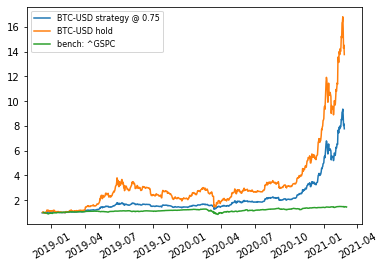

7.772813237330413


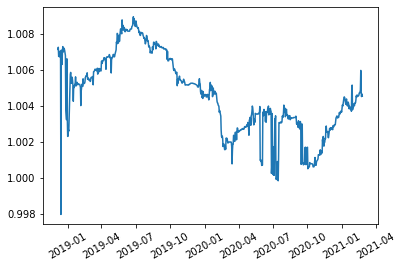

7.772813237330413
2.264894310679892


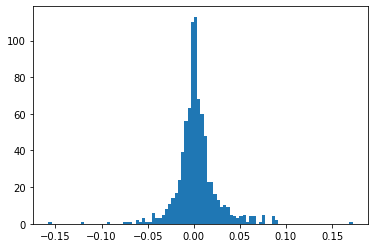

In [19]:

ret_data =  runningLog.set_index('date')['portValue'].pct_change()
cumulative_ret_data = (ret_data + 1).cumprod()

ret_data2 = data[runningLog.set_index('date').index[1]:runningLog.set_index('date').index[-1]]['Close'].pct_change()
cum_ret_data2 = (ret_data2 + 1).cumprod()

sp500_data = benchData[runningLog.set_index('date').index[1]:]['Close'].pct_change()
sp500_cumulative_ret_data = (sp500_data + 1).cumprod()

plt.plot(cumulative_ret_data,label=name + " strategy @ " + str(BuyFundsPercent) )
plt.plot(cum_ret_data2,label=name + " hold")
plt.plot(sp500_cumulative_ret_data,label="bench: " + benchName)
plt.legend(loc="upper left",fontsize=8)

plt.xticks(rotation=30) 

plt.show()

print(cumulative_ret_data[-1])

plt.plot((set['ExpectedReturn']+1))
plt.xticks(rotation=30) 
#len(set['ExpectedReturn']+1)

runningLog

plt.show()
print(cumulative_ret_data.iloc[-1])
plt.hist(runningLog.set_index('date')['portValue'].pct_change().dropna(), bins='auto')  # arguments are passed to np.histogram
print(runningLog['portValue'].dropna().pct_change().sum())

